# CNN Image Classificator Project
## Freddy Roldan Rivero

### Data loading and preprocessing

First we will be importing the necessary labraries and loading the dataset 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau





2024-09-26 21:24:30.550722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 21:24:30.550834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 21:24:30.551978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 21:24:30.558864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 21:24:31.293510: W tensorflow/compiler/tf2

Since the dataset (CIFAR-10) is already split into training and testing data, we will be loading it as such

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)


Scale pixel values from 0, 255 to 0, 0.1, since we need a smaller set of pixels


In [3]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


We use one hot enconding to encode the labels. This is important for multiclass classification tasks.

In [4]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[0])


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Implementing augmentation with ImageDataGenerator. This will help the model to better genralize among the objects that is observing. This will rotate and flip random images in the training set for it to accomplish this. 

In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotate images randomly by 20 degrees
    width_shift_range=0.2,     # Shift images horizontally by 20%
    height_shift_range=0.2,    # Shift images vertically by 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    zoom_range=0.2,            # Random zoom on images
    brightness_range=[0.8, 1.2]  # Randomly adjust brightness
)
datagen.fit(x_train)


Now we will define class names for each CIFAR-10 labels

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


Plotting some sample images from the dataset in a 3x3 grid for 9 images 

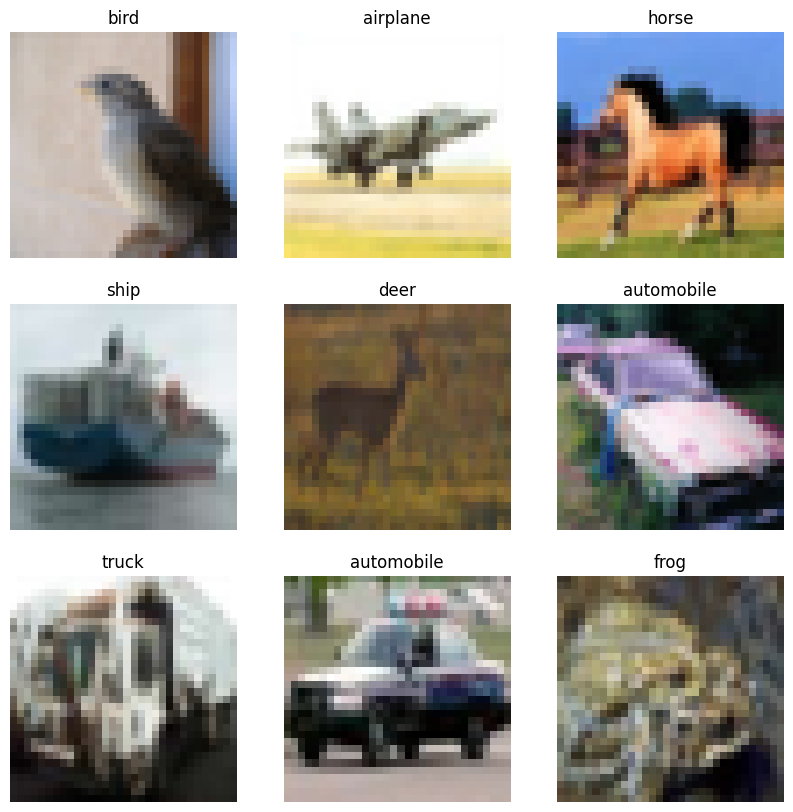

In [7]:
import random

def plot_random_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    
    indices = random.sample(range(len(images)), num_images)
    
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        label_index = np.argmax(labels[idx])
        plt.title(class_names[label_index])
        plt.axis('off')
    
    plt.show()

plot_random_images(x_train, y_train, class_names)


### Model Architecture

We initialize the model as a sequential API to model a linear stack of layers with one input tensor and one output tensor each

In [8]:
model=Sequential()

2024-09-26 21:24:34.968062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 21:24:34.994787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 21:24:34.994977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

for the 1st block we add the Input layer, 2 convolutional layers with 64 filters (or kernel) of 3x3 each to stride over each image. The input shape is of 32x32 pixels - this size multiplied by 3 since the images of this dataset are in color, meaning it has 3 channels, Red, Green and Blue.

Later update - After noticing some overfitting, batch normalization layers were added after each convolutional layer

ReLu function: After this 1st layer we apply the ReLu activation function, which introduces non-linearity to the network (things in real life as we see it are non-linear so it makes sense). Without the ReLu act. function, the model would be limited to learning simple linear relationshifs. It provides the following layer with non-linearity, so it will fine tune each time it passes the information

A padding of 1 was added to capture all information of each sample

Finally we apply max pooling size of 2, 2, which reduces the spatial dimensions by half, helping reduce the computational complexity while retaining important features. 

We increase by the double the number of filters for each block

We flatten the model after the 5th block  into a one dimensional vector and then fully connect with a dropout of 0.5 (50%) The dropout helps us ‘cripple’ the network on purpose to reduce overfitting

Finally, the output layer is a final dense layer with 10 neurons (corresponding to the 10 classes in CIFAR-10). Then we use the softmax activation function to convert the raw output into probabilities for each class. 

Later update: after some noticed overfitting in the validation process, we augmented the dropout slightly to 0.7

In [9]:

# Block 1: 2 Convolutional layers followed by MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2: 2 Convolutional layers followed by MaxPooling
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3: 3 Convolutional layers followed by MaxPooling
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Block 4: 3 Convolutional layers followed by MaxPooling
#model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

#Block 5: 3 Convolutional layers followed by MaxPooling
#model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten before fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Correct usage
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Correct usage
model.add(Dropout(0.6))

# Output layer
model.add(Dense(10, activation='softmax'))

- Compiling the model: 



Adam is our gradient descent optimizer responsible to adjust the weights and reach the global minimum using bias correction. UPDATE: Adding a learning rate scheduler to reduce learning rate when validation accuracy plateaus


In [10]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)



 - Defining the EarlyStopping callback

This will make the training stop if the validation loss doesn't improve for 5 consecutive epochs. The best weights are restored at the end to ensure the model doesn't overfit. 

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

- Training the model

we fit the model with Eary Stopping. We also implement clear_session() to free some memory and go faster.

In [12]:
from keras.backend import clear_session
clear_session()

In [13]:
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr]  # Include reduce_lr here
)

Epoch 1/50


2024-09-26 21:24:41.649361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-09-26 21:24:43.298360: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efcfcbabd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-26 21:24:43.298549: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-26 21:24:43.303938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727385883.402367    6918 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 13s 15ms/step - loss: 2.6124 - accuracy: 0.4190 - val_loss: 3.4323 - val_accuracy: 0.1614 - lr: 1.0000e-04
Epoch 2/50
391/391 [==============================] - 5s 12ms/step - loss: 1.8442 - accuracy: 0.6013 - val_loss: 1.5986 - val_accuracy: 0.6653 - lr: 1.0000e-04
Epoch 3/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5028 - accuracy: 0.6830 - val_loss: 1.3703 - val_accuracy: 0.7147 - lr: 1.0000e-04
Epoch 4/50
391/391 [==============================] - 5s 12ms/step - loss: 1.2872 - accuracy: 0.7360 - val_loss: 1.2386 - val_accuracy: 0.7422 - lr: 1.0000e-04
Epoch 5/50
391/391 [==============================] - 5s 12ms/step - loss: 1.1236 - accuracy: 0.7748 - val_loss: 1.1475 - val_accuracy: 0.7608 - lr: 1.0000e-04
Epoch 6/50
391/391 [==============================] - 5s 12ms/step - loss: 0.9839 - accuracy: 0.8092 - val_loss: 1.0914 - val_accuracy: 0.7651 - lr: 1.0000e-04
Epoch 7/50
391/391 [==============================

313/313 [==============================] - 1s 2ms/step


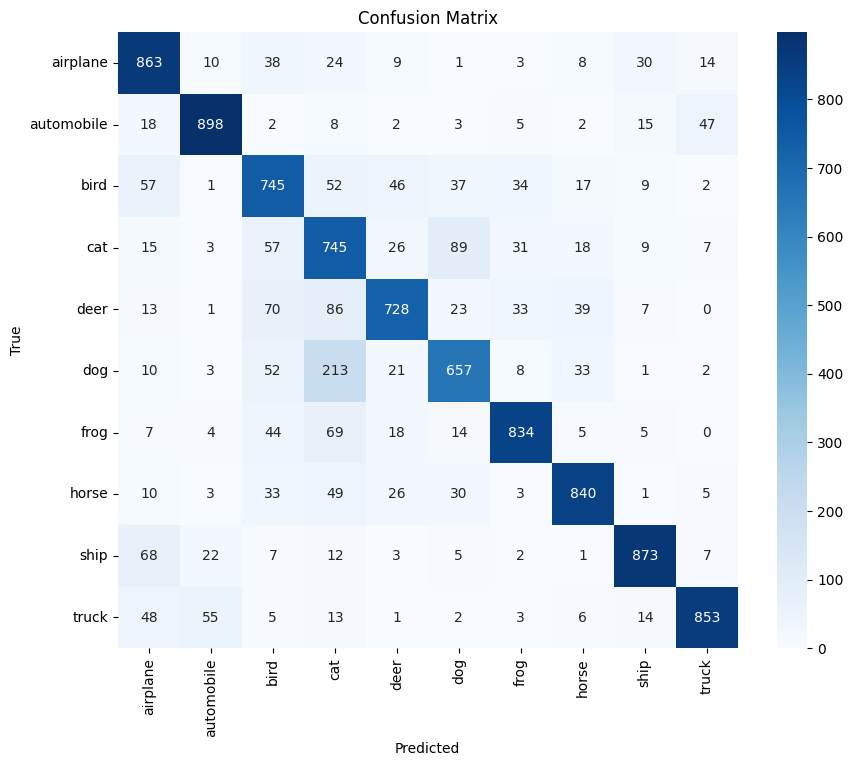

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test data
y_pred = model.predict(x_test)

# Convert one-hot encoded predictions and labels back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


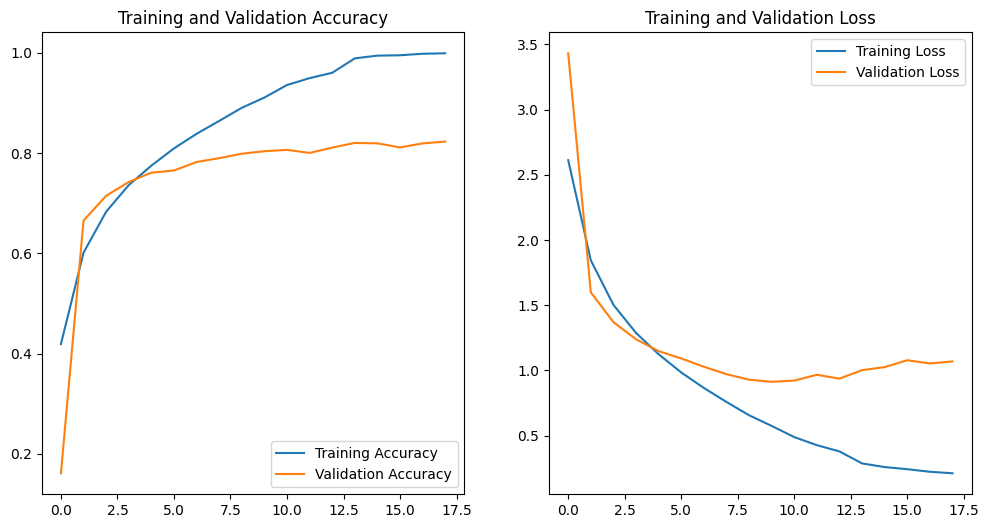

In [15]:
# Plot the training and validation accuracy and loss curves

def plot_training_curves(history):
    # Extract accuracy and loss data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot the curves
plot_training_curves(history)


# Transfer Learning

I will be using VGG16 since it's has been shown to perform well on various image classification tasks due to its deep architecture (16 layers), it has been pre-trained on the ImageNet dataset ant it excels in feature extraction for images.

Since the VGG16 is trained with 224x224 images, I will resize my dataset to such sizes 

In [16]:
# Imports and setup
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf

In [17]:
# Clear previous session if needed
K.clear_session()

Pre-processing data

In [18]:

# Load CIFAR-10 and resize images to 224x224
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding of labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Resize images to 224x224
def resize_images(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224
    return image, label


In [22]:
# Create TensorFlow datasets with resizing
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(resize_images).batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(resize_images).batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

Implementing Data Augmentation

In [24]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
datagen.fit(x_train)


Model Architecture and Transfer learning

In [27]:
# Load VGG16 without the top dense layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing all VGG16 layers
for layer in VGG_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of VGG16 for fine-tuning
for layer in VGG_model.layers[-4:]:
    layer.trainable = True

# Create a new model with Batch Normalization, Dropout, and Regularization
model_2 = models.Sequential([
    VGG_model,
    
    # New convolutional layers after VGG16 base
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Global Average Pooling to replace Flatten
    layers.GlobalAveragePooling2D(),
    
    # Fully connected layers with regularization and dropout
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer with 10 classes (CIFAR-10)
    layers.Dense(10, activation='softmax')
])

# Compile the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Corrected learning rate
    metrics=['accuracy']
)

# Callbacks to reduce learning rate and apply early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the data generator and the callbacks
history = model_2.fit(
    train_ds,  # Or replace with datagen.flow(x_train, y_train, batch_size=32) for augmentation
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model_2.evaluate(test_ds)
print(f'Test Accuracy: {test_acc}')

Epoch 1/50
782/782 [==============================] - 68s 78ms/step - loss: 2.4965 - accuracy: 0.4918 - val_loss: 2.3086 - val_accuracy: 0.5587 - lr: 1.0000e-04
Epoch 2/50
782/782 [==============================] - 70s 90ms/step - loss: 1.7425 - accuracy: 0.6908 - val_loss: 1.7045 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 3/50
782/782 [==============================] - 61s 77ms/step - loss: 1.4883 - accuracy: 0.7594 - val_loss: 1.5030 - val_accuracy: 0.7576 - lr: 1.0000e-04
Epoch 4/50
782/782 [==============================] - 60s 77ms/step - loss: 1.3020 - accuracy: 0.8048 - val_loss: 1.9687 - val_accuracy: 0.6303 - lr: 1.0000e-04
Epoch 5/50
782/782 [==============================] - 61s 78ms/step - loss: 1.1371 - accuracy: 0.8448 - val_loss: 1.3592 - val_accuracy: 0.7805 - lr: 1.0000e-04
Epoch 6/50
782/782 [==============================] - 61s 78ms/step - loss: 0.9828 - accuracy: 0.8740 - val_loss: 1.6502 - val_accuracy: 0.7147 - lr: 1.0000e-04
Epoch 7/50
782/782 [==============

Plotting results

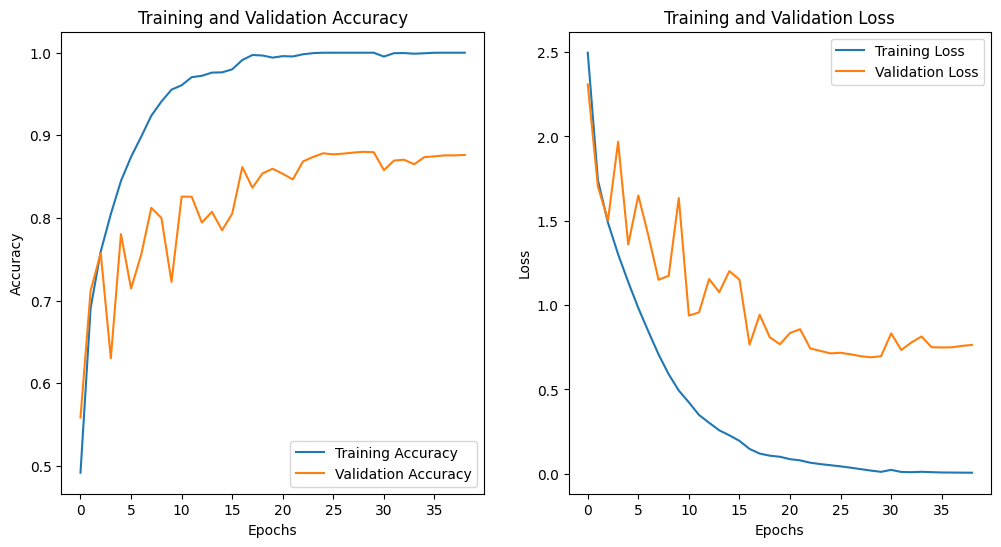

In [28]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

157/157 [==============================] - 10s 65ms/step


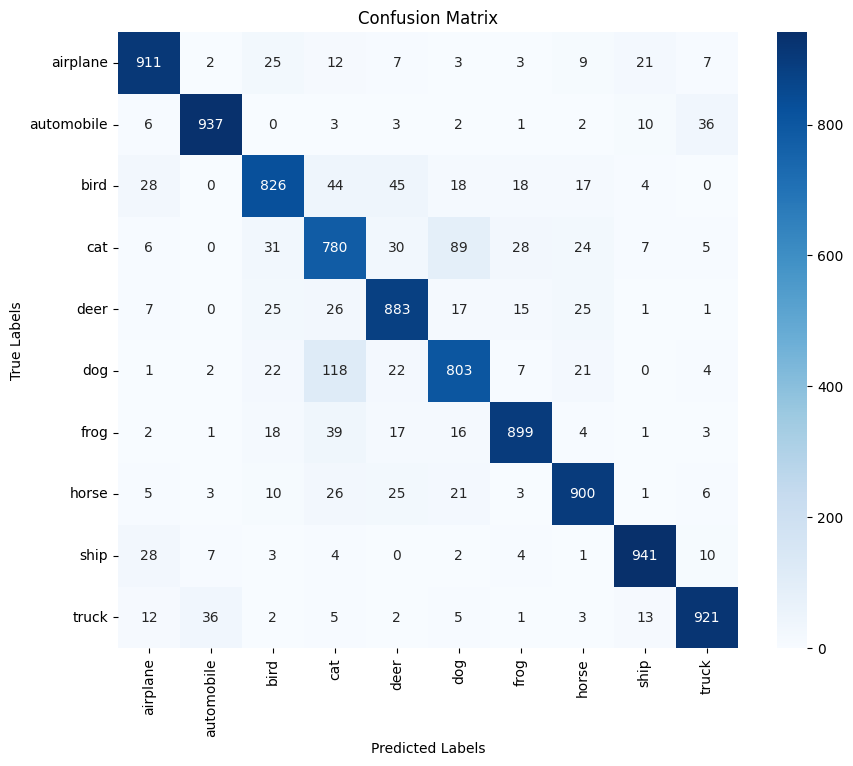

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the labels for the test data
y_pred = model_2.predict(test_ds)  # Replace 'model_VGG' with your model variable name
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded test labels back to class labels
y_true_classes = np.concatenate([np.argmax(y, axis=1) for x, y in test_ds], axis=0)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


Loading the pretrained model

Adding custom layers

Compile the model

Train the model